# Notes:
- came to the conclusion that we might not need this
- if we do, there are plenty of things that need to be fixed here

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import substring, length, col, expr, trim
from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyspark.ml.feature import StandardScaler

In [17]:
spark = SparkSession.builder \
    .appName('airlines_delay')\
    .config('spark.jars', '../../jars/snowflake-jdbc-3.13.6.jar, ../../jars/spark-snowflake_2.12-2.9.0-spark_3.1.jar') \
    .getOrCreate()

In [28]:
cols = ['Year',
    'Quarter',
    'Month',
    'DayofMonth',
    'DayOfWeek',
    'FlightDate',
    'DOT_ID_Reporting_Airline',
    'IATA_CODE_Reporting_Airline',
    'Tail_Number',
    'Flight_Number_Reporting_Airline',
    'OriginAirportID',
    'DestAirportID',
    'CRSDepTime',
    'DepTime',
    'DepDelay',
    'DepDelayMinutes',
    'CRSArrTime',
    'ArrTime',
    'ArrDelay',
    'ArrDelayMinutes',
    'Cancelled',
    'CancellationCode',
    'Diverted',
    'CRSElapsedTime',
    'ActualElapsedTime',
    'AirTime',
    'Flights',
    'Distance',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

In [29]:
file_path = "../../datasets/delays_new.csv"

delay = spark.read.csv(file_path, header=False)
delay = delay.toDF(*cols)

In [31]:
delay = delay.sample(False, 0.005, seed=0)

In [32]:
delay

DataFrame[Year: string, Quarter: string, Month: string, DayofMonth: string, DayOfWeek: string, FlightDate: string, DOT_ID_Reporting_Airline: string, IATA_CODE_Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: string, OriginAirportID: string, DestAirportID: string, CRSDepTime: string, DepTime: string, DepDelay: string, DepDelayMinutes: string, CRSArrTime: string, ArrTime: string, ArrDelay: string, ArrDelayMinutes: string, Cancelled: string, CancellationCode: string, Diverted: string, CRSElapsedTime: string, ActualElapsedTime: string, AirTime: string, Flights: string, Distance: string, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [33]:
delay = delay.withColumn('ArrDelay', delay.ArrDelay.cast('double'))
delay = delay.withColumn("y", when(delay.ArrDelay > 30.0, 1.0).otherwise(0.0))

In [34]:
major_df = delay.filter(delay.y == 0.0)
minor_df = delay.filter(delay.y == 1.0)
ratio = major_df.count()/minor_df.count()

In [35]:
delay.select(*['Year',
             'Month',
             'DayofMonth',
             'DayOfWeek',
             'IATA_CODE_Reporting_Airline',
             'CRSDepTime',
             'y'
           ]).show(4)

+----+-----+----------+---------+---------------------------+----------+---+
|Year|Month|DayofMonth|DayOfWeek|IATA_CODE_Reporting_Airline|CRSDepTime|  y|
+----+-----+----------+---------+---------------------------+----------+---+
|2014|    5|        16|        5|                         B6|      1022|0.0|
|2014|    5|        16|        5|                         B6|      1055|0.0|
|2014|    5|        16|        5|                         B6|      1000|0.0|
|2014|    5|        16|        5|                         B6|      1115|0.0|
+----+-----+----------+---------+---------------------------+----------+---+
only showing top 4 rows



In [36]:
ratio

8.394708171206226

In [37]:
sampled_majority_df = major_df.sample(False, 1/ratio)

In [38]:
sampled_majority_df.count()

25677

In [39]:
minor_df.count()

25700

In [40]:
combined_df = sampled_majority_df.unionAll(minor_df)

In [41]:
def preprocess_inputs(df):
    
    df = df.withColumn("DepHour", when(length('CRSDepTime') > 2, expr("substring(CRSDepTime, 1, length(CRSDepTime)-2)")).otherwise('0'))

    for col_name in ['Distance', 'AirTime']:
        df = df.withColumn(col_name, df[col_name].cast('double'))

    
    df = df.select(*['Year',
                     'Month',
                     'DayofMonth',
                     'DayOfWeek',
                     'IATA_CODE_Reporting_Airline',
                     'OriginAirportID',
                     'DestAirportID',
                     'AirTime',
                     'DepHour',
                     'y'
    ])    
    return df



def gen_preprocessor(df):
    cate_cols =  ['Year',
                     'Month',
                     'DayofMonth',
                     'DayOfWeek',
                     'IATA_CODE_Reporting_Airline',
                     'OriginAirportID',
                     'DestAirportID',
                     'DepHour'
                     ]
    
    target_col = "y"
    num_cols = list(set(df.schema.names) - set(cate_cols) - set([target_col]))
    
    
    # String Indexing for categorical features
    indexers = [StringIndexer(inputCol=col, 
                              outputCol="{}_idx".format(col)) \
                              for col in cate_cols]
    
    # One-hot encoding for categorical features
    encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
                              outputCol="{}_oh".format(col)) \
                              for col in cate_cols]

    # Concat Feature Columns
    assembler = VectorAssembler(inputCols = num_cols + \
                            ["{}_oh".format(col) for col in cate_cols], 
                            outputCol = "_features")
    
    # Standardize Features
    scaler = StandardScaler(inputCol='_features', 
                            outputCol='features', 
                            withStd=True, withMean=False)

    preprocessor = Pipeline(stages = indexers + encoders + \
                                     [assembler, scaler]).fit(df)


    return preprocessor

In [42]:
df = preprocess_inputs(combined_df)

In [43]:
preprocessor = gen_preprocessor(df)
df_transformed = preprocessor.transform(df) 

In [44]:
rf = RandomForestClassifier(featuresCol='features', labelCol='y', numTrees=100, maxDepth=5)

In [45]:
rf_model = rf.fit(df_transformed)

In [46]:
predictions = rf_model.transform(df_transformed)

In [47]:
preds_vs_labels = predictions.select("prediction", "y")
preds_vs_labels = preds_vs_labels.withColumn('label', preds_vs_labels['y'])

In [48]:
preds_df = preds_vs_labels.toPandas()

In [49]:
preds_df

,prediction,y,label
0,1.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
51372,1.0,1.0,1.0
51373,0.0,1.0,1.0
51374,1.0,1.0,1.0
51375,0.0,1.0,1.0


In [50]:
def evaluate_model(y_true, y_pred):
    
   
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    print("Test Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred) * 100))
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

Test Accuracy: 62.14%


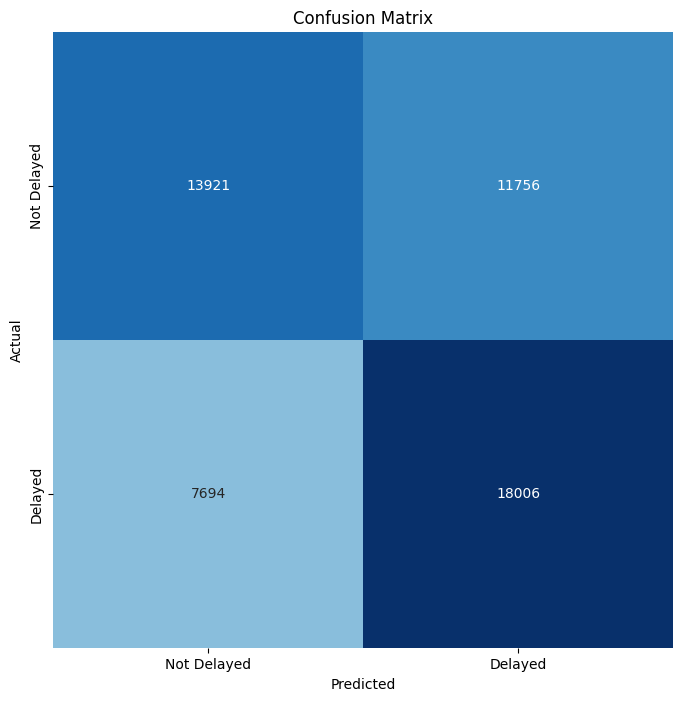

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.64      0.54      0.59     25677
     Delayed       0.60      0.70      0.65     25700

    accuracy                           0.62     51377
   macro avg       0.62      0.62      0.62     51377
weighted avg       0.62      0.62      0.62     51377



In [51]:
evaluate_model(preds_df.y, preds_df.prediction)